# Sentiment analysis using different model types

### Dataset preprocessing

In [10]:
import tensorflow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, SpatialDropout1D,LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras.models import load_model, save_model
import os 
#tensorflow.compat.v1.disable_eager_execution()

#tensorflow.config.run_functions_eagerly(False)

MODEL_DIR = os.path.join(os.getcwd(), '..', '..', 'resources','models')
DATA_PATH = os.path.join(os.getcwd(), '..', '..', 'resources', 'data', "sentiment_analysis")


In [11]:
def extract_review_and_sentiment(file): # Extracts the review and sentiment (0 for negative and 1 for positive) from the file
    reviews = []
    sentiments = []
    with open(os.path.join(DATA_PATH,file),'r') as f: 
        for line in f:
            review, sentiment = line.strip().split('\t')
            reviews.append(review)
            sentiments.append(sentiment)
    return reviews, sentiments

Number of reviews and sentiments for amazon_cells_labelled.txt:  1000 1000
Number of reviews and sentiments for imdb_labelled.txt:  1000 1000
Number of reviews and sentiments for yelp_labelled.txt:  1000 1000


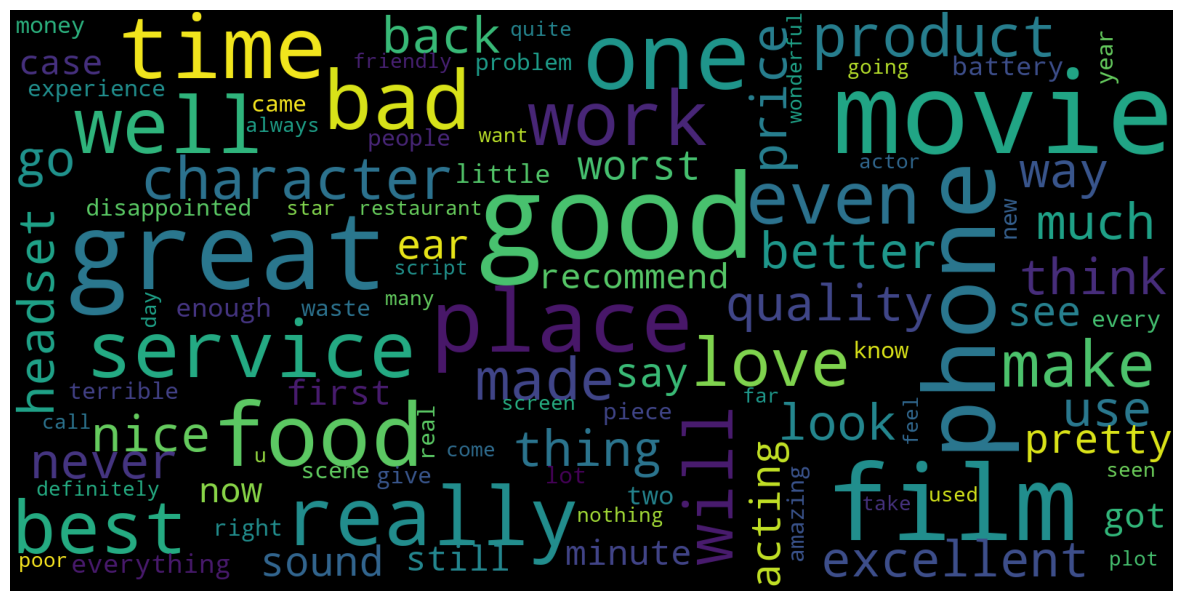

In [12]:

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def extract_all_reviews_and_sentiments(): # Extracts all the reviews and sentiments from all the files
   
    # we extract the reviews and sentiments from the files
    inputs1, outputs1 = extract_review_and_sentiment("amazon_cells_labelled.txt")
    inputs2, outputs2 = extract_review_and_sentiment("imdb_labelled.txt")
    inputs3, outputs3 = extract_review_and_sentiment("yelp_labelled.txt")

    print("Number of reviews and sentiments for amazon_cells_labelled.txt: ", len(inputs1), len(outputs1))
    print("Number of reviews and sentiments for imdb_labelled.txt: ", len(inputs2), len(outputs2))
    print("Number of reviews and sentiments for yelp_labelled.txt: ", len(inputs3), len(outputs3))
    
    inputs =inputs1 + inputs2+inputs3
    outputs = outputs1 +outputs2+outputs3
    outputs = [int(i) for i in outputs]

    return inputs, outputs


def generate_wordcloud(data, title=None):
    wordcloud = WordCloud(
        stopwords=stopwords,
        max_words=100,
        max_font_size=40,
        scale=4).generate(str(data))
    return wordcloud

inputs, outputs = extract_all_reviews_and_sentiments()
wordcloud = generate_wordcloud(inputs)
fig = plt.figure(1, figsize=(15, 15))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


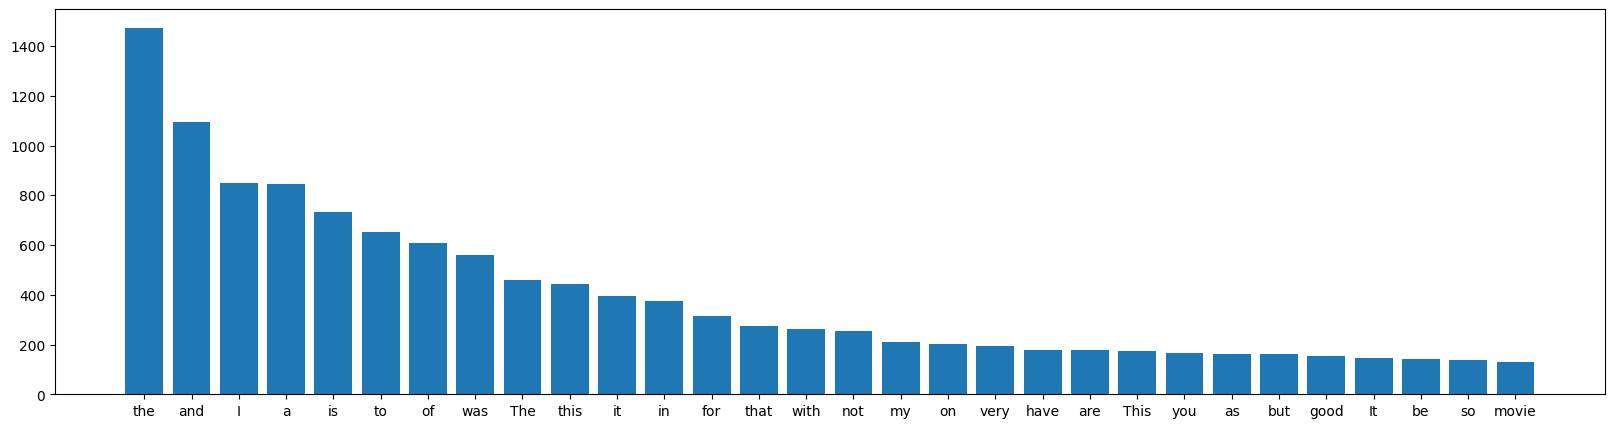

In [34]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def plot_most_common_words(inputs, n=10):

    plt.figure(figsize=(20, 5))
    words = []
    for review in inputs:
        words += review.split()
    counter = Counter(words)
    most_common = counter.most_common(n)
    most_common = dict(most_common)
    most_common = sorted(most_common.items(), key=lambda x: x[1], reverse=True)
    most_common = dict(most_common)
    plt.bar(most_common.keys(), most_common.values())
    plt.show()

plot_most_common_words(inputs, n=30)

#### Tokenization

In [4]:
import numpy as np
from nltk import word_tokenize
from nltk.corpus import wordnet
import re
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from textblob import Word
from keras.preprocessing.text import Tokenizer


lemmatizer = WordNetLemmatizer()
number_words_vocab = 2000

def remove_element_from_list(list, element):
    return [i for i in list if i != element]

def get_correct_pos_tag(word): # we reduce the words to their root using pos tags
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag)

def cleaning_tokens(texts): # 
    for i in range(len(texts)):

        words = texts[i].split()
        words = [re.sub(r'[^\w\s]','', word) for word in words]

        words_lower_case = [word.lower() for word in words]

        words_lemma = []
        for j in range(len(words_lower_case)): # we lowercase the words and reduce them to their root
            tag = get_correct_pos_tag(words_lower_case[j])
            words_lemma.append(Word(words_lower_case[j]).lemmatize(tag)) # we get the lemma of the word
      
        texts[i]= " ".join(words_lemma) # each text is a succesion of word lemmas separated by a space
    return texts

inputs = cleaning_tokens(inputs)
tokenizer = Tokenizer(num_words=number_words_vocab, split=' ') # will tokenisze, which means creating a vocabulary and transform each word into its numerical representation. Not all the words are kept, only the most frequent ones

tokenizer.fit_on_texts(inputs)
texts = tokenizer.texts_to_sequences(inputs) # will transform each text in texts to a sequence of integers
texts = pad_sequences(texts) # will pad the sequences to the same length, which is the length of the longest sequence
texts = np.array(texts)
print(texts.shape)

outputs = np.array(outputs)


(3000, 56)


In [5]:
import numpy as np

outputs = np.array(outputs).reshape(-1, 1) # we reshape the outputs to have the right shape for the one hot encoder
print(outputs)

print(outputs.shape)



[[0]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
(3000, 1)


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(texts, outputs, train_size = 0.8, random_state = 42,shuffle=True)


### First model : feedforward model 

In [14]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
feed_forward_model = Sequential(
    layers=[
        Dense(input_dim=X_train.shape[1], units=32, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(1, activation='sigmoid'),
    ]
)

feed_forward_model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
feed_forward_model.summary()
history_feed_forward = feed_forward_model.fit(texts, outputs, epochs=100, batch_size=1000, validation_split=0.1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                1824      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,985
Trainable params: 1,921
Non-trainable params: 64
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 45ms/step - loss: 0.9308 - accuracy: 0.5115 - val_loss: 3.2050 

### Performance plots

In [24]:
def plot_performance(model,history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    scores = model.evaluate(X_test, Y_test, verbose=0)
    print("Test accuracy: %.2f%%" % (scores[1]*100))

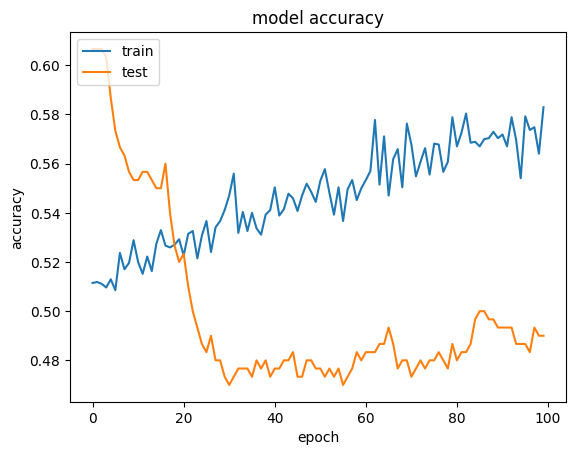

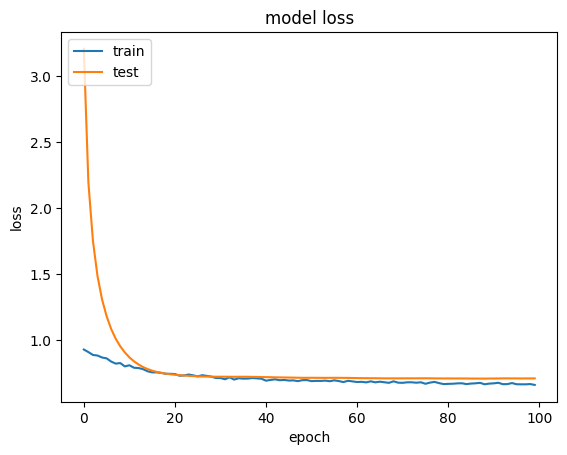

Test accuracy: 58.67%


In [16]:
plot_performance(feed_forward_model,history_feed_forward)


Analysis : the model overfits rapidly and the test accuracy is not very good.

In [ ]:
feed_forward_model.save(os.path.join(MODEL_DIR,'feed_forward_model.h5'))

In [ ]:
feed_forward_model = load_model(os.path.join(MODEL_DIR,'feed_forward_model.h5'))

## Second model : LSTM model

In [5]:
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K
from keras import Input
from keras.layers import Dense, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Dropout, BatchNormalization
from keras.models import Model 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,roc_auc_score,average_precision_score,balanced_accuracy_score
from sklearn.metrics import classification_report\

number_words_vocab = 2000

def create_model_lstm():

    input_layer = Input(shape=(3000,))
    embedding_layer = Embedding(number_words_vocab, 128)(input_layer)
    lstm_layer = LSTM(64)(embedding_layer)
    dense_layer = Dense(32, activation='relu')(lstm_layer)
    dropout_layer = Dropout(0.2)(dense_layer)
    batchnorm_layer = BatchNormalization()(dropout_layer)
    dense_layer_2 = Dense(1, activation='sigmoid')(batchnorm_layer)
    model = Model(inputs=input_layer, outputs=dense_layer_2)
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.005), loss="binary_crossentropy", metrics=["accuracy"])
    return model

lstm_model = create_model_lstm()
lstm_model.summary()
#history_LSTM = lstm_model.fit(X_train, Y_train, epochs=20, batch_size=1000, validation_split=0.1)

#loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose=0)
#print('Accuracy: %f' % (accuracy*100))



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3000)]            0         
                                                                 
 embedding (Embedding)       (None, 3000, 128)         256000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                             

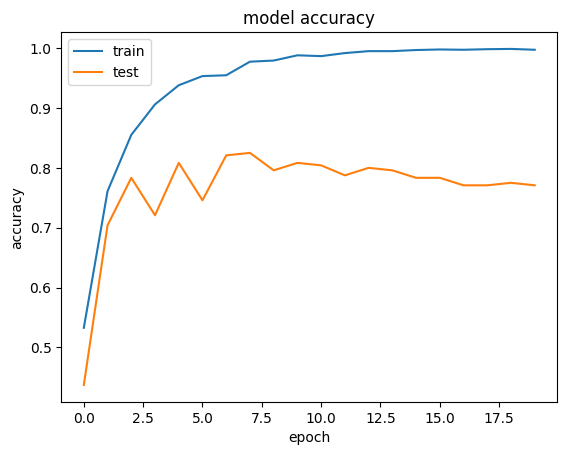

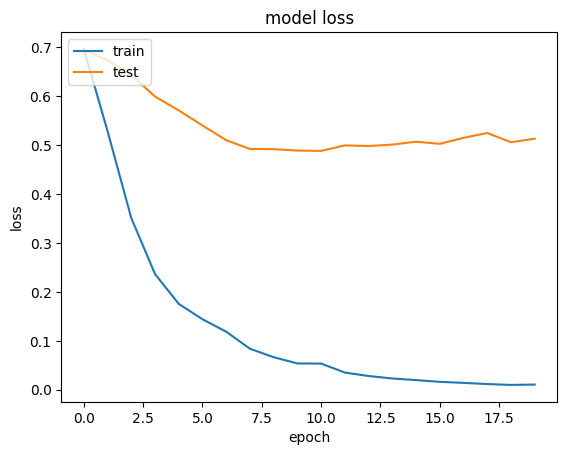

Test accuracy: 75.00%


In [25]:
plot_performance(lstm_model,history_LSTM)

Analysis : the LSTM model performs better than the feedforward model. The test accuracy is higher and the model does not overfit as much as the feedforward model.

In [26]:
lstm_model.save(os.path.join(MODEL_DIR,'lstm_model.h5'))

In [27]:
lstm_model = load_model(os.path.join(MODEL_DIR,'lstm_model.h5'))

## Transformer model

In [ ]:
!pip install transformers

In [13]:
# !pip3 install transformers
# !pip3 install torch
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification 
from transformers import Trainer, TrainingArguments
import pandas as pd
import numpy as np 

inputs,outputs = extract_all_reviews_and_sentiments()

outputs = np.array(outputs).reshape(len(outputs)) # we reshape the outputs to have the right shape for the one hot encoder
print(outputs.shape)
inputs = np.array(inputs)


print((inputs).shape)
X_train, X_test, Y_train, Y_test = train_test_split(inputs, outputs, train_size = 0.8, random_state = 42,shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 42,shuffle=True)


(3000,)
(3000,)


In [14]:
X_train = list(X_train)
X_test = list(X_test)
X_val = list(X_val)


## tokenization

We must use the Bert tokenizer to tokenize words.

In [15]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(X_train, padding="max_length", truncation=True)# split sentences into tokens adds tokens to separate sentences and pads the sentences to the same length
test_encodings = tokenizer(X_test, padding="max_length", truncation=True)
val_encodings = tokenizer(X_val, padding="max_length", truncation=True)


In [16]:
# now labels need to converted to tensorflow dataset objects 
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), Y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), Y_val))


The distillbert is used for the training. BERT uses a transformer, an attention based model, to learn contextual relations between words in a text.
Dilbert is small and fast version of BERT. It is trained on a subset of the data used to train BERT base. It is 60% smaller than BERT base, runs 40% faster while preserving over 95% of BERT’s performance as measured on the GLUE language understanding benchmark.

In [13]:
!pip3 install --upgrade tensorflow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [17]:
from transformers import TFDistilBertForSequenceClassification

tf.compat.v1.enable_eager_execution()


Bert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english', num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
Bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])






Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
history_Bert_model = Bert_model.fit(train_dataset.shuffle(1000).batch(64), epochs=3, batch_size=128, validation_data=val_dataset.shuffle(1000).batch(32))

Epoch 1/3


2022-11-23 13:55:17.288190: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


34/34 [==============================] - 1538s 45s/step - loss: 0.2194 - accuracy: 0.9301 - val_loss: 0.1516 - val_accuracy: 0.9458
Epoch 2/3
34/34 [==============================] - 1517s 44s/step - loss: 0.0713 - accuracy: 0.9782 - val_loss: 0.1950 - val_accuracy: 0.9458
Epoch 3/3
34/34 [==============================] - 1485s 44s/step - loss: 0.0250 - accuracy: 0.9944 - val_loss: 0.2253 - val_accuracy: 0.9542


In [21]:
Bert_model.save_weights(os.path.join(MODEL_DIR,'Bert_model.h5'))


In [25]:
Bert_model.load_weights(os.path.join(MODEL_DIR,'Bert_model.h5'))

In [36]:
loss, accuracy = Bert_model.evaluate(test_dataset.batch(32), verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 94.833332


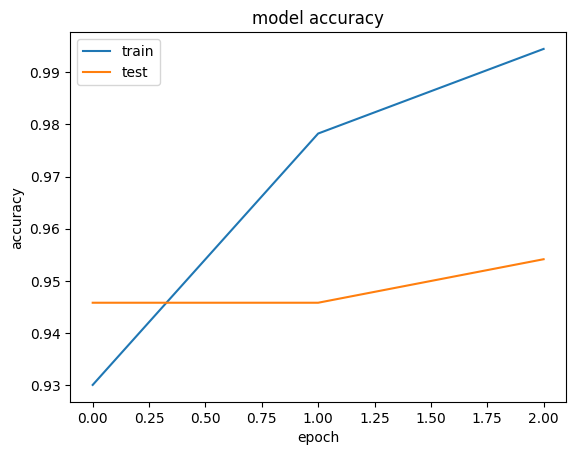

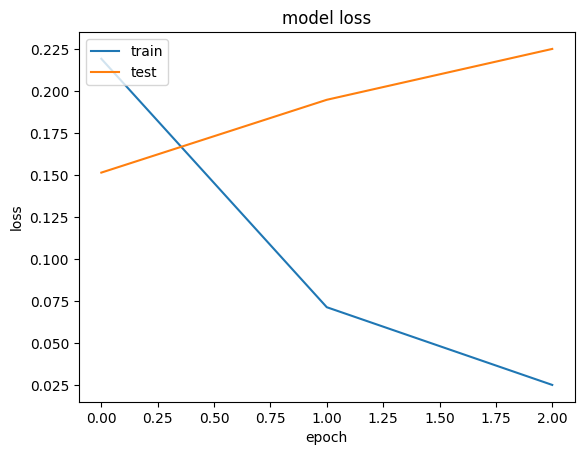

In [28]:
def plot_performance(model,history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_performance(Bert_model,history_Bert_model) 

Analysis : Out of all the models tested, the transformer is the one that performs the best. The test accuracy is higher than the other models and the model does not overfit as much as the other models.